Обучите алгоритм REINFORCE на любой среде из библиотеки gym, кроме Pong.

Документацию по средам gym можно найти по следующей ссылке: https://gym.openai.com/envs/

Обратите внимание на вкладки `Toy text`, `Classic control`, `Box2D`, `Atari`, и `Algorithms` слева на странице. Вам нужно выбрать подходящую среду из одной из этих вкладок.
______________________________________________________________________

Скачиваем нужные файлы для библиотеки gym.

Обратите внимание, что этот этап нужен лишь для некоторых сред из библиотеки.

In [1]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-10-22 16:01:30--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   261KB/s    in 44s     

2021-10-22 16:02:15 (247 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (P

Импортируем все нужные модули и библиотеки, подключаемся к диску.

In [2]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Model, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1515520/45929032 bytes (3.3%)4620288/45929032 bytes (10.1%)7593984/45929032 bytes (16.5%)10567680/45929032 bytes (23.0%)13492224/45929032 bytes (29.4%)16474112/45929032 bytes (35.9%)19398656/45929032 bytes (42.2%)22446080/45929032 bytes (48.9%)25354240/45929032 bytes (55.2%)28221440/45929032 bytes (61.4%)31031296/45929032 bytes (67.6%)33759232/45929032 bytes (73.5%)

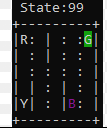

В этом задании позволяется использовать любую среду. Мы решили использовать среду `taxi-v3` (та же, которая использовалась в ультра-про разборе предыдущего занятия).

Может показаться, что это простая среда для обучения алгоритмов - но это только частично правда. Среда `taxi-v3` явно создана для алгоритма Q-обучения (причем, не с нейронной сетью, а обычного алгоритма). Решение использовать алгоритм REINFORCE для такой задачи не самый хороший, и вряд ли стоит так делать на практике (на практике, алгоритм REINFORCE хорошо работает на простых задачах, которые не возможно решить используя Q-таблицу). Однако, мы всё равно используем эту среду, чтобы продемоснтрировать общие подходы к построению архитектуры сети в разных задачах.

In [3]:
env = gym.make('Taxi-v3')          #Создаем игровую среду через библиотеку gym
state = env.reset()                #Начинаем новый эпизод, извлекаем состояние
print("Пример состояния:", state)  #Отображаем пример состояние (будет скалярное число)
print("Пространство действий:", env.action_space) #Смотрим на размер пространства действий

Пример состояния: 249
Пространство действий: Discrete(6)


Далее, мы создадим нашу нейронную сеть.

Нужно вспомнить, что в данной среде, состояния подаются в виде скалярного числа. То есть, каждое число обозначает отдельное состояние. По этому, мы используем слой `Embedding` в архитектуре, который присвоет отдельный образ в латентном пространстве для каждого состояния.

In [4]:
max_state_num = env.observation_space.n            #Извлекаем количество уникальных состояний в среде
action_space = env.action_space.n                  #Извлекаем количество уникальных действий в каждом состоянии
latent_dim = 32                                    #Задаем размерность латентного пространства (32-мерное пространство)
gamma = 0.9 #Задаем значение гаммы

input_layer = Input((1,))                                                  #Задаем входной слой нейронной сети (принимает на вход всего одно значение)
embedding_layer = Embedding(max_state_num, latent_dim, input_length = 1)(input_layer) #Задаем Embedding слой (резервируем его на 500 состояний, указываем что длина последовательности состовляет один элемент)
flatten_layer = Flatten()(embedding_layer)                                 #Добавляем выравнивающий слой
output_layer = Dense(action_space, activation = 'softmax')(flatten_layer)  #Добавляем выходной слой, где имеется один нейрон для каждого действия (и активационная функция softmax)

model = Model(input_layer, output_layer)                  #Создаем объект нейронной сети
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy') #Компилируем модель

Нужно не забыть объявить функцию для предобработки полученных наград. Данная функция работает с непрерывными наградами (нужно отметить, что функцию для непрерывных наград можно использовать и для скудных наград, но функцию для скудных наград нельзя использовать для непрерывных наград).

In [10]:
  #Объявляем функцию для предобработки наград (непрерывные награды). Эта функция принимает на вход список "сырых" наград, и возвращает обработанные награды.
  def preprocess_rewards(rewards): 
    processed_rewards = np.zeros_like(rewards).astype(np.float32) #Инициализируем новый массив нулями, куда будем записывать предобрадотанные награды
    running_add = 0 #Инициализируем значение скользящей суммы нулём
    for i in reversed(range(0, len(rewards))): #Проходимся черех массив наград в обратном порядке
      running_add = running_add * gamma + rewards[i] # sum * y (gamma) + reward (псевдо-уравнения бэллмена)
      processed_rewards[i] = running_add         #Устанавливаем значение награды в соответствии уравнения бэллмена
    return processed_rewards.flatten()           #Возвращаем одномерный список наград

Также, создадим функцию для обучения модели.

In [11]:
def train_model(states, actions, rewards): #Функция принимает на вход массив состояний среды, массив действий, и массив наград.
  rewards = preprocess_rewards(rewards)
  model.train_on_batch(states, actions, sample_weight = rewards) #Модель обучается на всём эпизоде в рамках одного пакета.

Создадим функцию, которая будет принимать состояние на вход, и возвращать действие. Данный алгоритм является стахостичным, по этому модель предсказывает вероятности принятия каждого действия (а не само действие).

In [12]:
def choose_action(state):             #Функция принимает на вход состояние среды
  state = np.array([state])           #Переводим состояние в numpy-массив с нужной размерностью для нейронной сети
  predictions = model.predict(state)  #Делаем предсказание модели, которая возвращает вероятности принятия каждого действия
  action_index = np.random.choice(action_space, p = predictions.flatten()) #Выбираем рандомный индекс по предсказанным вероятностям
  return action_index                 #Возвращаем действие

Также создадим функции для отображения суммарных наград за все эпизоды в процессе обучения. Подобная функция используется в всех занятиях по обучению с подкреплением.

In [13]:
#Создаем функцию для визуализации результата
def plot_rewards(rewards_list):
  output.clear() #Удаляем предидущий вывод ячейки
  plt.figure(figsize = (20, 8))

  plt.plot(rewards_list, label = "Награда за эпизод")                          #Устанавливаем большой размер полотна
  plt.plot(moving_average(rewards_list), label = "Скользящее среднее награды") #Отрисовываем скользящие средние награды
  plt.xlabel("Эпизод", fontsize = 16)                                    #Добавляем лейблы осей
  plt.ylabel("Награда", fontsize = 16)
  plt.title("Награды за все эпизоды", fontsize = 24)                     #Добавляем заголовок к графику
  plt.legend()                                                           #Добавляем легенду к графику

  plt.show()   #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Дальше, нужно создать цикл обучение.

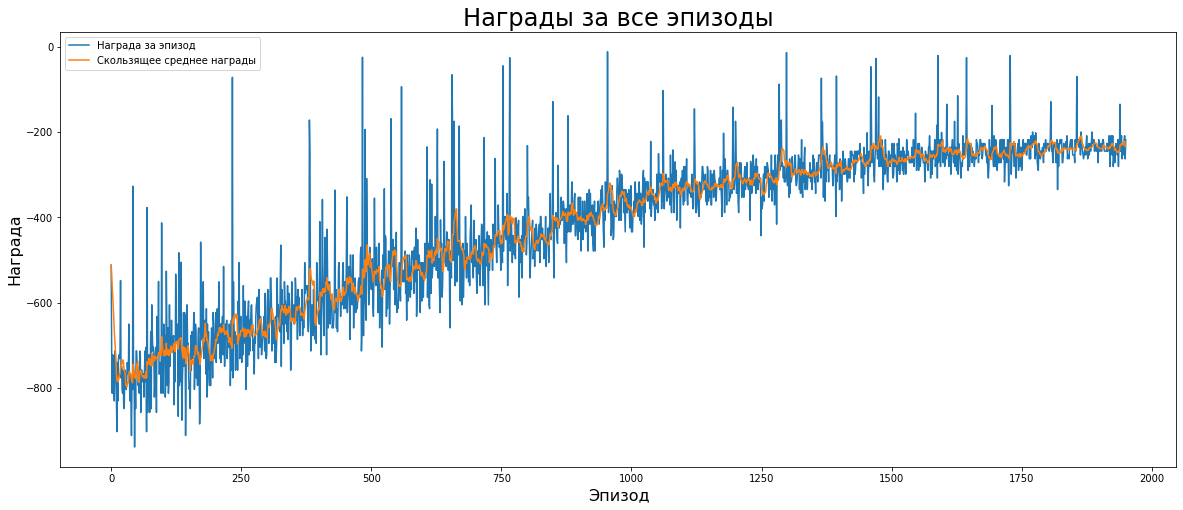

In [14]:
all_episode_rewards = []  #Создаем список куда будем добавлять сумму наград за весь эпизод

num_episodes = 2000       #Задаем количество эпизодов, по которым будем обучаться

for episode_number in range(num_episodes): #В цикле проходим по всем эпизодам
  state = env.reset()                      #Начинаем новый эпизод, извлекаем состояние среды
  interval_reward = 0                      #Инициализируем награду за эпизод как 0
  done = False                             #Указываем что эпизод ещё не завершился

  episode_states = []                      #Создадим список где будем хранить все состояния среды в эпизоде.
  episode_actions = []                     #Создадим список где будем хранить все действия в эпизоде.
  episode_rewards = []                     #Создадим список где будем хранить все награды в эпизоде.

  while not done:                          #Пока не дошли до конца эпизода:
    
    action = choose_action(state)          #Выбираем действие по текущему состоянию, используя ранее написанную функцию
    
    next_state, reward, done, info = env.step(action) #Подаем действие в среду, получаем следующее состояние, награду, статус завершение эпизода, и прочее
    
    episode_states.append(state)                    #Добавляем состояние в список состояний
    episode_actions.append(action)                  #Добавляем действие в список состояний
    episode_rewards.append(reward)                  #Добавляем награду в список состояний

    interval_reward += reward                       #Добавляем полученную награду в переменную которая считает сумму наград за эпизод
    state = next_state                              #Записываем следующее состояние среды (которое ранее хранили в другой переменной)

  all_episode_rewards.append(interval_reward)       #Добавляем сумму наград за эпизод в список
  
  #Вызоваем функцию для обучения модели в конце эпизода, подаем все данные в виде numpy массивов
  train_model(np.array(episode_states), np.array(episode_actions), np.array(episode_rewards)) 

  if episode_number % 50 == 0:                      #Каждые 50 эпизодов:
    plot_rewards(all_episode_rewards)               #Отображаем график с наградами за все эпизоды

## Посмотрим, как действует агент после обучения:

Сначала, мы зададим функцию, которая будет более граммотно выбирать нужные действия после обучения.

In [15]:
def choose_test_action(state):          #Функция принимает на вход состояние среды
  state = np.array([state])             #Переводим состояние в numpy-массив с нужной размерностью для нейронной сети
  predictions = model.predict(state)    #Делаем предсказание модели, которая возвращает вероятности принятия каждого действия
  action_index = np.argmax(predictions) #Действием будет являться максимальное предсказание модели
  return action_index                   #Возвращаем действие

Далее, мы отобразим действия агента в рамках одного эпизода.

In [16]:
import time         #Импортируем модуль time (используется для time.sleep чтобы была пауза между кадрами)

state = env.reset() #Начинаем новый эпизод, извлекаем текущее состояние
done = False                #Указываем что эпизод ещё не завершился
while not done:             #Пока не дошли до конца эпизода:
  output.clear(wait = True) #Удаляем предидущий вывод ячейки
  env.render()              #Отображаем состояние среды
  action = choose_test_action(state)           #Берём действие с максимальным вероятности кдаччификации
  state, reward, done, info = env.step(action) #Извлекаем новое состояние, награду, статус завершения игры, и прочую информацию
  time.sleep(0.2)                              #Делаем паузу программы на 0.2 секунды чтобы мы могли посмотреть на состояния в виде картинки

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
